In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Transfer Learning for Insect Classification in Agricultural Environments

**Goal**: Train a convolutional neural network to classify insects from natural agricultural environments using transfer learning.

This notebook adapts the PyTorch transfer learning tutorial for insect detection and classification.

## Dataset

- **12 insect classes**: Ants, Bees, Beetles, Caterpillars, Earthworms, Earwigs, Grasshoppers, Moths, Slugs, Snails, Wasps, Weevils
- **Training images**: 11,499
- **Validation images**: 1,095
- **Test images**: 546

## Transfer Learning Approaches

We'll explore two transfer learning strategies:

1. **Finetuning the ConvNet**: Initialize with a pretrained ResNet18 model and train all layers
2. **ConvNet as fixed feature extractor**: Freeze all layers except the final fully connected layer


## 1. Import Libraries and Setup


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode


## 2. Load and Prepare Data

We use data augmentation for training to improve model generalization:
- Random resized crop
- Random horizontal flip
- Random rotation
- Color jitter

For validation and testing, we only apply normalization.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datas'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train_organized'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'valid_organized'), data_transforms['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test_organized'), data_transforms['test'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Check for available accelerator (CUDA, MPS, etc.)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device")
print(f"\nDataset sizes:")
print(f"  Training: {dataset_sizes['train']}")
print(f"  Validation: {dataset_sizes['val']}")
print(f"  Test: {dataset_sizes['test']}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Classes: {class_names}")


Using cuda device

Dataset sizes:
  Training: 11499
  Validation: 1095
  Test: 546

Number of classes: 12
Classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


## 3. Visualize Sample Images


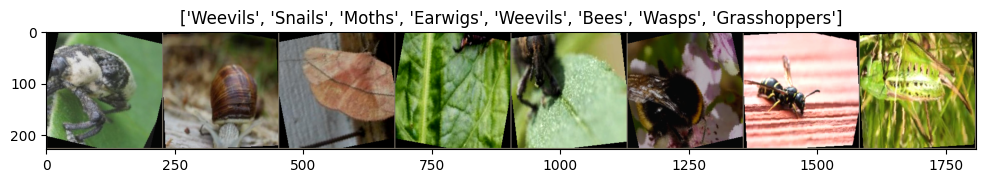

In [4]:
def imshow(inp, title=None):
    """Display image from Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])  # Show first 8 images

plt.figure(figsize=(12, 8))
imshow(out, title=[class_names[x] for x in classes[:8]])
plt.show()


## 4. Training Function

Generic function to train a model with:
- Learning rate scheduling
- Saving the best model
- Early stopping patience
- Training history tracking


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    """Train the model with early stopping."""
    since = time.time()
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        best_epoch = 0
        
        # Training history
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                # Save history
                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc.item())
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Deep copy the model if it's the best so far
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()
            
            # Early stopping
            if epoch - best_epoch >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')
        
        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    
    return model, history


## 5. Visualization Functions


In [6]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Val Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_model(model, num_images=12):
    """Display predictions for a few images."""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\\nActual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def visualize_model_predictions(model, img_path):
    """Make prediction on a single custom image."""
    was_training = model.training
    model.eval()
    
    img = Image.open(img_path)
    img_tensor = data_transforms['val'](img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)
        
        plt.figure(figsize=(8, 6))
        plt.axis('off')
        plt.title(f'Predicted: {class_names[preds[0]]} (Confidence: {conf[0]:.2%})')
        imshow(img_tensor.cpu().data[0])
        plt.show()
        
        model.train(mode=was_training)


## 7. Approach 1: Finetuning the Entire ConvNet

Load a pretrained ResNet18 model and replace the final fully connected layer to output 12 classes instead of 1000.
Train all parameters of the network.


In [7]:
# Load pretrained ResNet18
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Replace final fully connected layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # 12 classes

model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("Model architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_ft.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad):,}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ian/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


Model architecture:
Total parameters: 11,182,668
Trainable parameters: 11,182,668


### Train the Finetuned Model

This will take some time depending on your hardware. With GPU, it should take 10-20 minutes.


In [8]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                    num_epochs=25, patience=5)


Epoch 0/24
----------
train Loss: 1.0856 Acc: 0.6692
val Loss: 0.4438 Acc: 0.8676

Epoch 1/24
----------
train Loss: 0.6109 Acc: 0.8059
val Loss: 0.3726 Acc: 0.8785

Epoch 2/24
----------
train Loss: 0.4990 Acc: 0.8396
val Loss: 0.3643 Acc: 0.8849

Epoch 3/24
----------
train Loss: 0.4496 Acc: 0.8580
val Loss: 0.3621 Acc: 0.8895

Epoch 4/24
----------
train Loss: 0.4086 Acc: 0.8690
val Loss: 0.3715 Acc: 0.8849

Epoch 5/24
----------
train Loss: 0.3844 Acc: 0.8748
val Loss: 0.3574 Acc: 0.8913

Epoch 6/24
----------
train Loss: 0.3625 Acc: 0.8816
val Loss: 0.3781 Acc: 0.8849

Epoch 7/24
----------
train Loss: 0.3293 Acc: 0.8940
val Loss: 0.3515 Acc: 0.8959

Epoch 8/24
----------
train Loss: 0.3071 Acc: 0.9045
val Loss: 0.3461 Acc: 0.8922

Epoch 9/24
----------
train Loss: 0.2986 Acc: 0.9052
val Loss: 0.3545 Acc: 0.8913

Epoch 10/24
----------
train Loss: 0.2966 Acc: 0.9077
val Loss: 0.3504 Acc: 0.8968

Epoch 11/24
----------
train Loss: 0.2843 Acc: 0.9116
val Loss: 0.3448 Acc: 0.8950

Ep

### Visualize Training Results


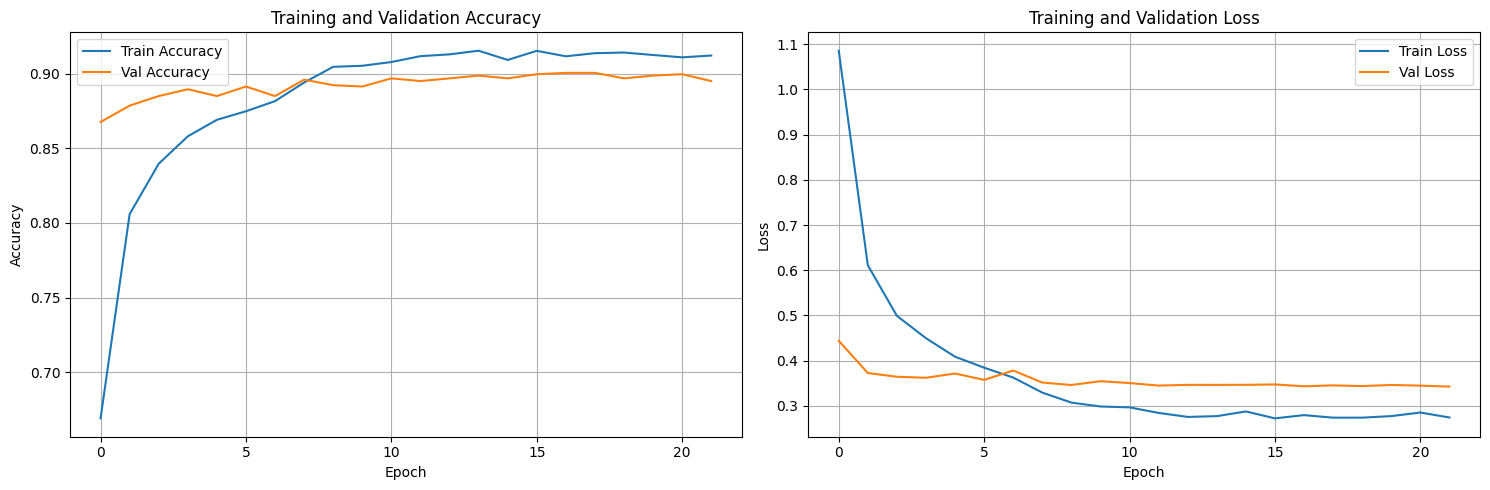

In [9]:
# Plot training history
plot_training_history(history_ft)


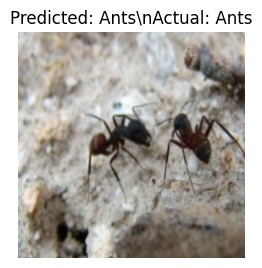

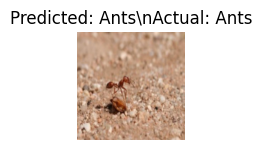

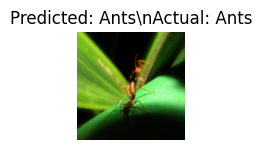

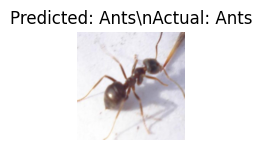

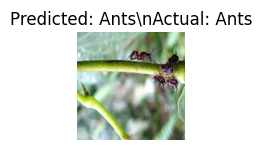

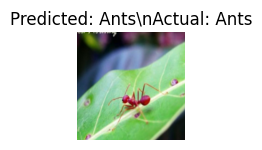

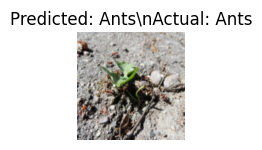

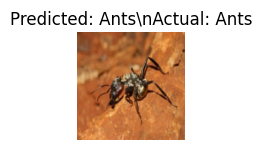

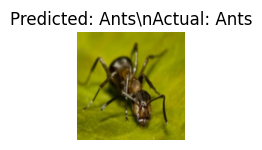

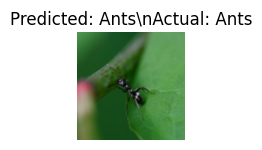

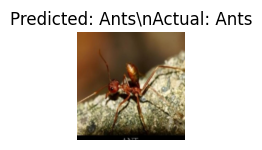

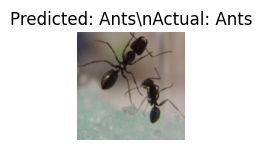

In [10]:
# Visualize predictions
visualize_model(model_ft, num_images=12)


### Evaluate on Test Set


Test Accuracy: 0.8974\n
Classification Report:
              precision    recall  f1-score   support

        Ants       0.93      0.96      0.95        54
        Bees       0.86      0.95      0.90        40
     Beetles       0.84      0.66      0.74        41
Caterpillars       0.79      0.80      0.80        46
  Earthworms       0.86      0.93      0.89        27
     Earwigs       0.90      0.75      0.81        59
Grasshoppers       0.83      0.92      0.88        38
       Moths       1.00      0.96      0.98        47
       Slugs       0.84      0.93      0.89        46
      Snails       0.98      1.00      0.99        44
       Wasps       0.92      0.96      0.94        46
     Weevils       0.97      0.97      0.97        58

    accuracy                           0.90       546
   macro avg       0.89      0.90      0.89       546
weighted avg       0.90      0.90      0.90       546



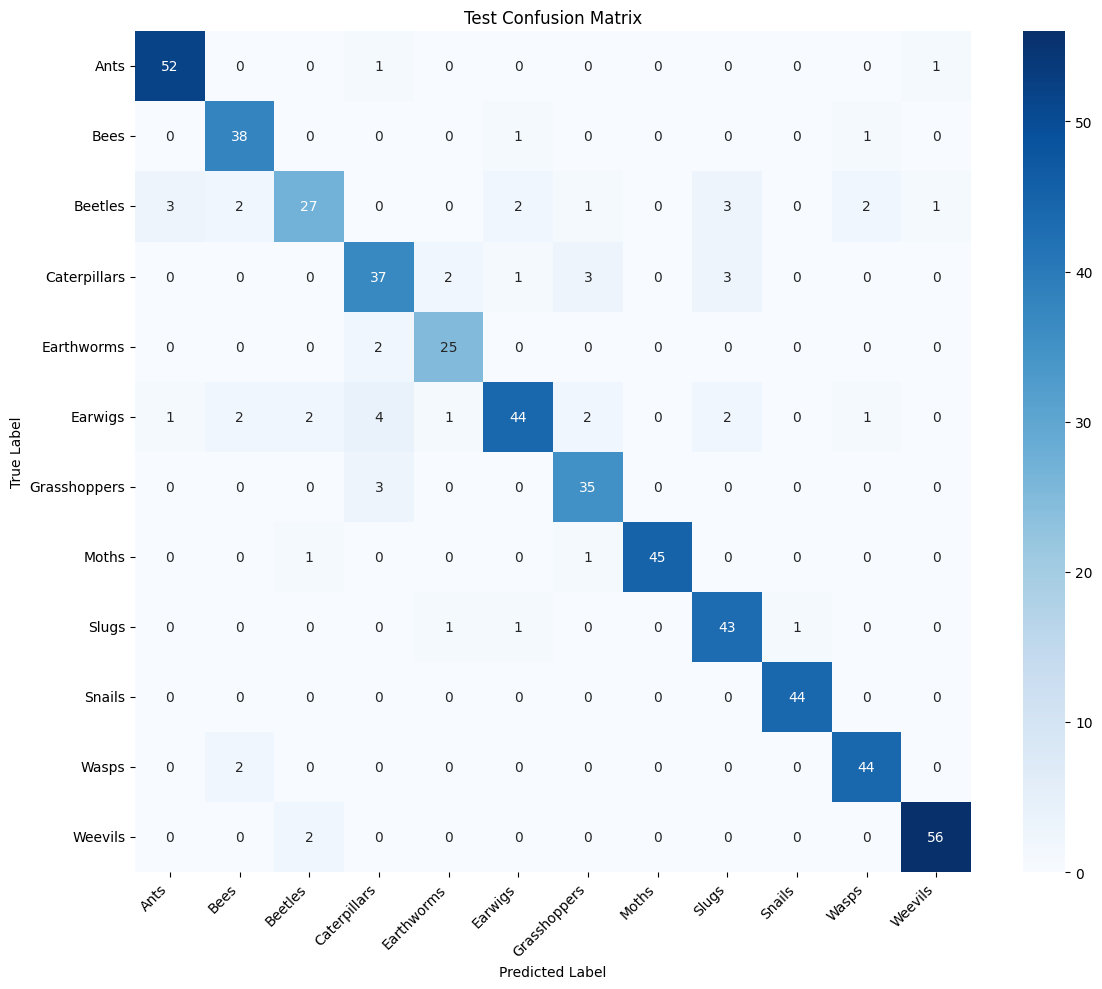

In [13]:
test_acc_ft, preds_ft, labels_ft = evaluate_model(model_ft, dataloaders['test'], 'Test')


### Save the Finetuned Model


In [14]:
# Save model
torch.save(model_ft.state_dict(), 'insect_classifier_finetuned.pth')
print("Model saved as 'insect_classifier_finetuned.pth'")


Model saved as 'insect_classifier_finetuned.pth'


## 8. Approach 2: ConvNet as Fixed Feature Extractor

Freeze all layers except the final fully connected layer. Only train the final layer.


In [7]:
# Load pretrained ResNet18
model_conv = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Replace final fully connected layer (new layer has requires_grad=True by default)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))  # 12 classes

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_conv = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print("Model architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_conv.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_conv.parameters() if p.requires_grad):,}")


Model architecture:
Total parameters: 11,182,668
Trainable parameters: 6,156


### Train the Feature Extractor Model

This should be faster than finetuning since we're only training the final layer.


In [8]:
model_conv, history_conv = train_model(model_conv, criterion, optimizer_conv,
                                        exp_lr_scheduler_conv, num_epochs=25, patience=5)


Epoch 0/24
----------
train Loss: 1.5181 Acc: 0.5522
val Loss: 0.8164 Acc: 0.7644

Epoch 1/24
----------
train Loss: 1.0221 Acc: 0.6965
val Loss: 0.6763 Acc: 0.8073

Epoch 2/24
----------
train Loss: 0.9234 Acc: 0.7168
val Loss: 0.6068 Acc: 0.8292

Epoch 3/24
----------
train Loss: 0.8754 Acc: 0.7284
val Loss: 0.5884 Acc: 0.8265

Epoch 4/24
----------
train Loss: 0.8406 Acc: 0.7374
val Loss: 0.5670 Acc: 0.8219

Epoch 5/24
----------
train Loss: 0.8446 Acc: 0.7325
val Loss: 0.5503 Acc: 0.8265

Epoch 6/24
----------
train Loss: 0.8175 Acc: 0.7434
val Loss: 0.5305 Acc: 0.8411

Epoch 7/24
----------
train Loss: 0.7860 Acc: 0.7532
val Loss: 0.5407 Acc: 0.8356

Epoch 8/24
----------
train Loss: 0.7891 Acc: 0.7516
val Loss: 0.5315 Acc: 0.8411

Epoch 9/24
----------
train Loss: 0.7738 Acc: 0.7565
val Loss: 0.5361 Acc: 0.8402

Epoch 10/24
----------
train Loss: 0.7632 Acc: 0.7586
val Loss: 0.5365 Acc: 0.8429

Epoch 11/24
----------
train Loss: 0.7867 Acc: 0.7516
val Loss: 0.5494 Acc: 0.8283

Ep

KeyboardInterrupt: 

### Visualize Training Results


In [ ]:
# Plot training history
plot_training_history(history_conv)


In [ ]:
# Visualize predictions
visualize_model(model_conv, num_images=12)


### Evaluate on Test Set


In [ ]:
test_acc_conv, preds_conv, labels_conv = evaluate_model(model_conv, dataloaders['test'], 'Test')


### Save the Feature Extractor Model


In [ ]:
# Save model
torch.save(model_conv.state_dict(), 'insect_classifier_feature_extractor.pth')
print("Model saved as 'insect_classifier_feature_extractor.pth'")


## 9. Approach 3: DenseNet-121 with Optimized Training

DenseNet (Densely Connected Convolutional Networks) connects each layer to every other layer in a feed-forward fashion. 

**Key Advantages:**
- Alleviates vanishing gradient problem
- Strengthens feature propagation
- Encourages feature reuse
- Reduces number of parameters

**Best Training Practices for DenseNet:**
- Lower learning rate (0.0001) due to dense connections
- Adam optimizer for adaptive learning
- Higher dropout for regularization
- Cosine annealing for learning rate scheduling

## 9. Compare Both Approaches


In [ ]:
print("="*60)
print("COMPARISON OF TRANSFER LEARNING APPROACHES")
print("="*60)
print(f"\n1. Finetuning (train all layers):")
print(f"   - Test Accuracy: {test_acc_ft:.4f}")
print(f"   - Training epochs: {len(history_ft['train_acc'])}")
print(f"\n2. Feature Extractor (train final layer only):")
print(f"   - Test Accuracy: {test_acc_conv:.4f}")
print(f"   - Training epochs: {len(history_conv['train_acc'])}")
print("\n" + "="*60)


## 10. Inference on Custom Images

Use the trained model to make predictions on any image from the test set or your own images.


In [ ]:
# Example: Make prediction on a test image
# Replace with your own image path
import random
import glob

# Get a random test image
test_images = glob.glob('datas/test_organized/*/*.jpg')
if test_images:
    sample_image = random.choice(test_images)
    print(f"Testing on: {sample_image}")
    visualize_model_predictions(model_ft, sample_image)
else:
    print("No test images found")


## Summary

In this notebook, we:
1. Organized the insect dataset for transfer learning
2. Applied data augmentation to improve generalization
3. Implemented two transfer learning approaches:
   - **Finetuning**: Training all layers of a pretrained ResNet18
   - **Feature Extraction**: Only training the final classification layer
4. Evaluated both models on a held-out test set
5. Visualized predictions and analyzed results

### Key Takeaways:
- Transfer learning allows us to leverage knowledge from ImageNet for insect classification
- Data augmentation helps prevent overfitting on agricultural images
- Both approaches can achieve good results, with finetuning typically providing better accuracy
- The feature extraction approach trains faster but may have slightly lower accuracy

### Next Steps:
- Try different pretrained models (ResNet50, EfficientNet, etc.)
- Experiment with different augmentation strategies
- Implement ensemble methods
- Deploy the model for real-time insect detection


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, dataset_name='Test'):
    """Evaluate model and display metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'{dataset_name} Accuracy: {accuracy:.4f}\\n')
    
    # Classification report
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels
